# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data Acquisition](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction to Business Problem <a name="introduction"></a>

   ### Background 
  
  My client is a successful entrepreneur in Europe. It's only been 3 years since he started his business. But now, in 2020, He has 16 Fried Chicken Restaurants in big cities of Europe like Paris, Berlin, Brussels, Amsterdam etc.  And now, he wants to expand his business in other countries. He has a particular interest in Canada. So, he wants to open a new restaurant in Toronto.
  
  ### Business Problem

In this project we will try to find an optimal location for a new __Fried Chicken Restaurant__ in Toronto, Canada. Since there are lots of restaurants in Toronto, we will try to detect locations that are not already so crowded with venues, especially  restaurants. By the way, the place should not be too secluded. 
We are particularly interested in a potential neighborhood with no Fried Chicken Restaurant in vicinity. We would also prefer locations as close to the city center as possible to attract more customers, assuming that the first two conditions are met.

   We will use some data science and machine learning techniques to generate a few most promissing neighborhoods based on these criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by my client.
  

   ### About Toronto
  
  Toronto is Canada’s largest city and a world leader in such areas as business, finance, technology, entertainment and culture. Its large population of immigrants from all over the globe has also made Toronto one of the most multicultural cities in the world. 
  So Toronto has full potential but also is a very challenging district to open a business because of high competition. 
  
  ### Target Audience
   
   Specifically, this report will be targeted to my client who wants to find the optimal location to open a new Fried Chicken Joint in Toronto. But the other stakeholders interested in the same kind of opportunity can also benefit from it.



## 2. Data Acquisition <a name="data"></a>

- In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood. So we will scrape the data that contain neighborhoods names and their postal code from the following Wikipedia page:  'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'


- Then, we will merge it with the data that contain all the geographical coordinates of the neighborhoods thanks to the following csv file:
“https://cocl.us/Geospatial_data”


- Finally, to get the locations(latitude and longitude) and other informations about various venues in Toronto, we will use __Foursquare’s API__. 

### Import libraries

In [1]:
import numpy as np # to handle data in a vectorized manner

import pandas as pd # for data analsysis
pd.set_option("display.max_columns", None) # to be able to see all columns
pd.set_option("display.max_rows", None) # to be able to see all rows

import json # to handle JSON files
from pandas.io.json import json_normalize # to tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # to handle requests
import urllib.request
from bs4 import BeautifulSoup # to parse HTML and XML documents

from sklearn.cluster import KMeans # import k-means from clustering stage

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering

print("Libraries imported.")

Libraries imported.


### A. Scrap the data from Wikipedia page into a DataFrame

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)  

__import the functions from "Beautiful Soup" which will let us parse and work with the HTML that we fetched from our Wiki page:__

In [3]:
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

In [4]:
# let's see the title of the web page as example
soup.title.string

'List of postal codes of Canada: M - Wikipedia'

To get an idea of the structure of the underlying HTML in our web page, we can view the HTML with __Soup’s prettify__ function

In [5]:
# to see the important part, look at the characters between 9000-9300
print(soup.prettify()[9000:9300])

a Post may be allocating the M0 FSA for high volume addresses.
      </p>
      <table class="wikitable sortable">
       <tbody>
        <tr>
         <th>
          Postal Code
         </th>
         <th>
          Borough
         </th>
         <th>
          Neighborhood
         </th>
       


The important part is starting with an HTML __table tag__ with a class identifier of __”wikitable sortable”__. 

Scroll down a little to see how the table is made up and you’ll see the rows start and end with __tr__ and __tr__ tags.

The top row of headers has __th__ tags while the data rows beneath for each club has __td__ tags. It’s in these tags that we will tell Python to extract our data from.

Let's look at the table :

In [6]:
# all_tables = soup.find_all('table')
# or just specify the table with a "wikitable sortable" class ID
# doing so, we will get rid of some informations unnecessary

table = soup.find('table', class_ = 'wikitable sortable')
# Let's see first 100 character of the table 
print(table.prettify()[0:100])

<table class="wikitable sortable">
 <tbody>
  <tr>
   <th>
    Postal Code
   </th>
   <th>
    Boro


There are 3 columns in our table that we want to scrape the data from.
__so we will set up 3 empty lists (A, B, C) to store our data in.__

*  We know that the table is set up in rows (starting with 'tr' tags) with the data sitting within 'td' tags in each row. We aren’t too worried about the header row with the 'th' elements as we know what each of the columns represent by looking at the table.
* To start with, we want to use the Beautiful Soup ‘find_all’ function again and set it to look for the string ‘tr’. We will then set up a FOR loop for each row within that array and set Python to loop through the rows, one by one.

* Within the loop we are going to use find_all again to search each row for 'td' tags with the ‘td’ string. We will add all of these to a variable called ‘cells’ and then check to make sure that there are 3 items in our ‘cells’ array.

* If there are then we use the find(text=True)) option to extract the content string from within each 'td' element in that row and add them to the A-C lists we created at the start of this step

In [7]:
A = []
B = []
C = []

for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True).rstrip('\n'))
        B.append(cells[1].find(text=True).rstrip('\n'))
        C.append(cells[2].find(text=True).rstrip('\n'))

We create a dataframe, assigning each of the lists A-C into a column with the name of our source table columns (PostalCode, Borough, Neighborhood)

In [8]:
df = pd.DataFrame(A, columns=['PostalCode'])
df['Borough'] = B
df['Neighborhood'] = C
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


remove  __'Not Assigned'__ cells

In [9]:
df['Borough'].replace('Not assigned', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


for Neighborhood="Not assigned", make the value the same as Borough

In [10]:
# if there would be "not assigned" for Neighborhood column

for index, row in df.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]

Let's look at the shape 

In [11]:
df.shape

(103, 3)

### B. Load the coordinates from __"Geospatial_Coordinates.csv"__ file 

In [12]:
df_coor = pd.read_csv('Geospatial_Coordinates.csv')
df_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# rename the colum "Postal Code" as "PostalCode" to be able to merge based on it
df_coor.rename(columns = {'Postal Code' : 'PostalCode'}, inplace=True)
df_coor.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge two tables to get the coordinates

In [14]:
df = pd.merge(df, df_coor, on="PostalCode", how="left")
df_neighborhood = df 
df_neighborhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


__Use geopy library to get the latitude and longitude values of Toronto for mapping.__

In [15]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a __map__ of Toronto with neighborhoods superimposed on top

In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Borough'], df_neighborhood['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### C. Use Foursquare API to explore the venues

__Define Foursquare Credentials and Version__

In [17]:
CLIENT_ID = 'DZVNYQSZ2SFHRFNLHMRXC5TTGASDMYLVLQ2ZUTT34WHOOC44' 
CLIENT_SECRET = 'O4SY41AI0OETZA1KTIHWYIAFKFZYW5F3RW3JTCKR4SFBSLR1' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius=500

We will need the __get_category_type__ function to extract category of venue.

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

__NOTE :__ all the information we need is in the items key.

### Extract the data of venues in Toronto and make a dataframe from them

__we will need "getNearbyVenues" fonctionne__

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500): # radius is 500m so as not to leave the center of neighborhood 
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's write the code to run the above function on each neighborhood and create a new dataframe called Toronto_venues

In [20]:
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

In [21]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2115, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Let's find out how many unique categories can be curated from all the returned venues

In [22]:
print('There are {} uniques categories.'.format(Toronto_venues['Venue Category'].nunique()))

There are 266 uniques categories.


### Now we will search for 'Fried Chicken Restaurant'

In [23]:
df_chicken = Toronto_venues[Toronto_venues['Venue Category'] == 'Fried Chicken Joint'].reset_index(drop=True)
print(df_chicken.shape)
df_chicken.head()

(12, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Flock Rotisserie + Greens,43.659167,-79.389475,Fried Chicken Joint
1,Cedarbrae,43.773136,-79.239476,Popeyes Louisiana Kitchen,43.775930,-79.235328,Fried Chicken Joint
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Popeyes Louisiana Kitchen,43.754671,-79.442740,Fried Chicken Joint
3,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Joe Bird,43.638204,-79.380355,Fried Chicken Joint
4,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Union Chicken,43.644912,-79.382325,Fried Chicken Joint


## 3. Methodology <a name="methodology"></a>

We will try to find the possible locations that have normal restaurant and other types of venues density in addition to that they should don't have Fried Chicken Joint.

In the first step, we have collected the required data: The Neighborhoods and their locations and also the venues in each of these neighborhoods to see density.  

In the second step in our analysis, we will look at 'venues and restaurant density' across different areas of Toronto - we will use maps to identify a few promising areas close to center with moderate density of restaurants, neither too much nor too little.

In the third and final step, we will focus on the most promising areas and within those create clusters of locations (using k-means clustering) that meet some basic requirements established in discussion with entrepreneur. 

## 4. Analysis <a name="analysis"></a>

In [24]:
Toronto_venues.Neighborhood.value_counts()[0:10]

Toronto Dominion Centre, Design Exchange             100
Harbourfront East, Union Station, Toronto Islands    100
Commerce Court, Victoria Hotel                       100
Garden District, Ryerson                             100
First Canadian Place, Underground city               100
Stn A PO Boxes                                        94
Richmond, Adelaide, King                              93
St. James Town                                        76
Church and Wellesley                                  73
Fairview, Henry Farm, Oriole                          64
Name: Neighborhood, dtype: int64

#### So:
Like we decide at the beginning of this analysis, we want to find the neighborhoods that don't have too many venues because it may be risky for our new restaurant. In another aspect, we don't want to open it in a neighborhood that don't have much potential. So finally, after discussing with my client, we will focus on the neighborhoods that have more than 35 and less than 80 venues 500m near the center of the neighborhood.

In [25]:
most_venues=Toronto_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 80) & (most_venues.Neighborhood >= 35) ]
optimal_neigs = optimal_venues.index.tolist()

df_35_80 = pd.DataFrame()
for neig in optimal_neigs:
    df_35_80 = df_35_80.append(Toronto_venues[Toronto_venues['Neighborhood'] == neig], ignore_index=True)

In [26]:
most_venues=Toronto_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 80) & (most_venues.Neighborhood >= 35) ]
optimal_neigs = optimal_venues.index.tolist()
optimal_neigs


['St. James Town',
 'Church and Wellesley',
 'Fairview, Henry Farm, Oriole',
 'Central Bay Street',
 'Berczy Park',
 'Kensington Market, Chinatown, Grange Park',
 'Regent Park, Harbourfront',
 'St. James Town, Cabbagetown',
 'Little Portugal, Trinity',
 'The Danforth West, Riverdale',
 'Willowdale',
 'Studio District',
 'Runnymede, Swansea',
 'University of Toronto, Harbord',
 'Davisville']

In [27]:
df_35_80 = pd.DataFrame()
for neig in optimal_neigs:
    df_35_80 = df_35_80.append(Toronto_venues[Toronto_venues['Neighborhood'] == neig], ignore_index=True)
print(df_35_80.shape)
df_35_80.head()

(751, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
1,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
2,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
3,St. James Town,43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
4,St. James Town,43.651494,-79.375418,Versus Coffee,43.651213,-79.375236,Coffee Shop


#### Visualize the Fried Chicken Restaurant  and other venues 

In [28]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the central of Lille

# add populer spots as blue circle markers   
for lat, lng, label in zip(df_35_80['Venue Latitude'], df_35_80['Venue Longitude'], df_35_80['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill=True,
        color='blue',
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(venues_map) 


# add the Fried Chicken Joint as blue circle markers
for lat, lng, label in zip(df_chicken['Venue Latitude'], df_chicken['Venue Longitude'], df_chicken['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(venues_map)
    

# display map
venues_map

### Analyze Each Neighborhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_35_80[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood_1'] = df_35_80['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood_1,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,Hobby Shop,Hospital,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Strip Club,Supplement Shop,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
toronto_onehot.shape

(751, 177)

### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood_1').mean().reset_index()
toronto_grouped.head()

,Neighborhood_1,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,Hobby Shop,Hospital,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Spa,Sporting Goods Shop,Stationery Store,Steakhouse,Strip Club,Supplement Shop,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.0,0.017544,0.000000,0.000000,0.000000,0.017544,0.017544,0.035088,0.00000,0.000000,0.000000,0.017544,0.017544,0.0,0.035088,0.0,0.0,0.017544,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.035088,0.000000,0.000000,0.035088,0.0,0.000000,0.017544,0.052632,0.070175,0.0,0.0,0.017544,0.000000,0.017544,0.000000,0.017544,0.0,0.017544,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.000000,0.0,0.000000,0.017544,0.000000,0.0,0.0,0.017544,0.0,0.0,0.000000,0.000000,0.0,0.017544,0.017544,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017544,0.017544,0.017544,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.017544,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.017544,0.017544,0.0,0.017544,0.000000,0.0,0.0,0.017544,0.017544,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.017544,0.0,0.0,0.017544,0.0,0.000000,0.0,0.0,0.017544,0.0,0.0,0.000000,0.000000,0.0,0.0,0.017544,0.0,0.017544,0.000000,0.0,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.00000,0.017544,0.000000,0.0,0.000000,0.017544,0.0,0.017544,0.000000,0.000000,0.000000,0.017544,0.0,0.000000,0.017544,0.000000,0.000000,0.000000,0.0,0.017544,0.000000,0.0,0.0,0.000000,0.000000
1,Central Bay Street,0.000000,0.000000,0.0,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.032787,0.000000,0.000000,0.000000,0.0,0.000

In [32]:
toronto_grouped.shape

(15, 177)

### Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood_1']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood_1'] == hood].T.reset_index()
    temp.columns = ['venue_category ','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
  venue_category   freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.05
2        Beer Bar  0.04
3     Cheese Shop  0.04
4          Bakery  0.04


----Central Bay Street----
      venue_category   freq
0         Coffee Shop  0.18
1                Café  0.07
2  Italian Restaurant  0.07
3      Sandwich Place  0.05
4        Burger Joint  0.03


----Church and Wellesley----
       venue_category   freq
0  Japanese Restaurant  0.07
1          Coffee Shop  0.07
2     Sushi Restaurant  0.07
3           Restaurant  0.04
4            Gastropub  0.03


----Davisville----
  venue_category   freq
0    Dessert Shop  0.09
1     Pizza Place  0.09
2  Sandwich Place  0.09
3            Café  0.09
4             Gym  0.06


----Fairview, Henry Farm, Oriole----
        venue_category   freq
0        Clothing Store  0.11
1           Coffee Shop  0.09
2  Fast Food Restaurant  0.06
3   Japanese Restaurant  0.05
4            Restaurant  0.05


----Kensington Market, Chinatown, Grange Park---

#### Put that into a pandas dataframe

Firstly, write a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


Now, create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_1']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood_1'] = toronto_grouped['Neighborhood_1']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.rename(columns={'Neighborhood_1': 'Neighborhood'}, inplace=True)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Restaurant,Hotel,Eastern European Restaurant
1,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Thai Restaurant,Bubble Tea Shop,Burger Joint,Bar,Japanese Restaurant,Ice Cream Shop
2,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Men's Store,Mediterranean Restaurant,Gastropub,Pub,Gay Bar
3,Davisville,Dessert Shop,Pizza Place,Café,Sandwich Place,Gym,Italian Restaurant,Sushi Restaurant,Coffee Shop,Indian Restaurant,Farmers Market
4,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Bank,Shoe Store,Toy / Game Store,Bakery,Boutique


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

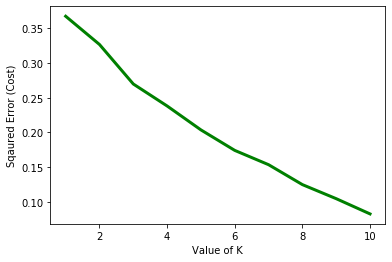

In [36]:
import matplotlib.pyplot as plt  

cost =[] 
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood_1', 1)

for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      

# plot the cost against K values   
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

In [37]:
# best number of k is 5
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighborhood

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(toronto_merged.shape)
toronto_merged = toronto_merged.dropna()
toronto_merged.head() # check the last columns!

(103, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Pub,Park,Theater,Café,Restaurant,Breakfast Spot,Hotel,Shoe Store
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1.0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Italian Restaurant,Cosmetics Shop,Creperie,Lingerie Store,Moroccan Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0.0,Coffee Shop,Cocktail Bar,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Restaurant,Hotel,Eastern European Restaurant
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Thai Restaurant,Bubble Tea Shop,Burger Joint,Bar,Japanese Restaurant,Ice Cream Shop
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Bank,Shoe Store,Toy / Game Store,Bakery,Boutique


Finally, let's visualize the resulting clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,"Regent Park, Harbourfront",0.0,Coffee Shop,Bakery,Pub,Park,Theater,Café,Restaurant,Breakfast Spot,Hotel,Shoe Store
20,Downtown Toronto,Berczy Park,0.0,Coffee Shop,Cocktail Bar,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Restaurant,Hotel,Eastern European Restaurant
24,Downtown Toronto,Central Bay Street,0.0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Thai Restaurant,Bubble Tea Shop,Burger Joint,Bar,Japanese Restaurant,Ice Cream Shop
33,North York,"Fairview, Henry Farm, Oriole",0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Bank,Shoe Store,Toy / Game Store,Bakery,Boutique
37,West Toronto,"Little Portugal, Trinity",0.0,Bar,Restaurant,Asian Restaurant,Vietnamese Restaurant,Men's Store,Vegetarian / Vegan Restaurant,Café,Dog Run,Cuban Restaurant,Record Shop
59,North York,Willowdale,0.0,Coffee Shop,Pizza Place,Ramen Restaurant,Restaurant,Sandwich Place,Bank,Grocery Store,Café,Pharmacy,Bubble Tea Shop
72,North York,Willowdale,0.0,Coffee Shop,Pizza Place,Ramen Restaurant,Restaurant,Sandwich Place,Bank,Grocery Store,Café,Pharmacy,Bubble Tea Shop
81,West Toronto,"Runnymede, Swansea",0.0,Coffee Shop,Café,Pub,Italian Restaurant,Pizza Place,Sushi Restaurant,Tea Room,Grocery Store,Bookstore,Falafel Restaurant
96,Downtown Toronto,"St. James Town, Cabbagetown",0.0,Coffee Shop,Park,Restaurant,Italian Restaurant,Bakery,Café,Pizza Place,Pub,Pharmacy,Indian Restaurant
99,Downtown Toronto,Church and Wellesley,0.0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Men's Store,Mediterranean Restaurant,Gastropub,Pub,Gay Bar


#### Cluster 2

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Downtown Toronto,St. James Town,1.0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Italian Restaurant,Cosmetics Shop,Creperie,Lingerie Store,Moroccan Restaurant
54,East Toronto,Studio District,1.0,Café,Coffee Shop,Bakery,Brewery,American Restaurant,Gastropub,Neighborhood,Cheese Shop,Pet Store,Clothing Store
79,Central Toronto,Davisville,1.0,Dessert Shop,Pizza Place,Café,Sandwich Place,Gym,Italian Restaurant,Sushi Restaurant,Coffee Shop,Indian Restaurant,Farmers Market
80,Downtown Toronto,"University of Toronto, Harbord",1.0,Café,Bookstore,Restaurant,Italian Restaurant,Japanese Restaurant,Bar,Bakery,College Arts Building,Sandwich Place,Pub
84,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",1.0,Café,Coffee Shop,Mexican Restaurant,Vietnamese Restaurant,Bakery,Bar,Gaming Cafe,Dessert Shop,Vegetarian / Vegan Restaurant,Pharmacy


#### Cluster 3

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,"The Danforth West, Riverdale",2.0,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Fruit & Vegetable Store,Pizza Place,Lounge


In [43]:
list_3_Neigs = ['Regent Park, Harbourfront','Kensington Market, Chinatown, Grange Park','Willowdale']

num_top_venues = 5

for hood in list_3_Neigs:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood_1'] == hood].T.reset_index()
    temp.columns = ['venue_category ','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Regent Park, Harbourfront----
  venue_category   freq
0     Coffee Shop  0.17
1          Bakery  0.06
2             Pub  0.06
3            Park  0.06
4         Theater  0.04


----Kensington Market, Chinatown, Grange Park----
         venue_category   freq
0                   Café  0.09
1            Coffee Shop  0.07
2  Vietnamese Restaurant  0.05
3                 Bakery  0.05
4     Mexican Restaurant  0.05


----Willowdale----
    venue_category   freq
0       Pizza Place  0.08
1       Coffee Shop  0.08
2  Ramen Restaurant  0.08
3     Grocery Store  0.05
4              Bank  0.05




### Observations:

Most of the interested neighborhoods according to our criteria are concentrated in Downtown Toronto.  

## 5. Results and Discussion <a name="results"></a>

- __Cluster 1 :__ Most of the neighborhoods fall into this cluster. There are mostly business areas with coffee shops, pizza places, restaurants, bar, etc.. There are also social activity venues. Some of the neighborhoods are close to the University of Toronto. So they are at the center of Toronto. So it means high cost high gain for a new business. Some of the neighborhoods are far away from the center.  


- __Cluster 2 :__ 40% of neighborhoods are in this cluster. There are mostly business areas with cafe, restaurants, bar, etc.. The neighborhoods are a little bit far from the center of Toronto. So it means high cost, high gain for a new business 

- __Cluster 3 :__ There are generally restaurants, coffee shops, etc. The neighborhoods are near the center of Toronto.

## 6. Conclusion <a name="conclusion"></a>


The purpose of this project was to identify Toronto areas close to center with normal number of restaurants and venues in order to aid my client in narrowing down the search for optimal location for a new Fried Chicken Restaurant. By seeing the density of restaurants and venues from Foursquare data we have identified the borouhgs that don't have a Fried Chicken Restaurant and also have a normal density of venues and restaurants. 

1. Regent Park, Harbourfront 
  
   -  According to the criteria and results of this analysis, it seems as the best option.
   -  The venues and restaurants density is not saturated.
   -  There is not other chicken restaurant so close.
   -  The neighborhood is close to the center of the city and other neighborhoods that don't have a fried chicken restaurant 


2. Kensington Market, Chinatown, Grange Park 

   - It may be the best option but there are two other fried chicken restaurants close by.   
   - High cost, high gain for a new business


3. Willowdale 

   - Good place to start with a new business in a new country to see how it will work. 
   - Moderate cost, moderate risk.

The final decission on optimal restaurant location will be made by my client based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood, etc.